# Olympic data | Exploration

## Packages

For simplicity, we use `kaggle` for now. Since the dataset is on the website, this makes it easy to download it and load it with `pandas`

In [1]:
%%capture
#to avoid output

!pip install -r ../requirements.txt

%load_ext autoreload
%autoreload 2

## Loading :3

In [2]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

df = kagglehub.dataset_load(KaggleDatasetAdapter.PANDAS, "heesoo37/120-years-of-olympic-history-athletes-and-results", 'athlete_events.csv') 
# Loading from Kaggle is easy and quite straightforward...

/home/pilgrim/miniconda3/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Data info & cleaning 

In [ ]:
df.head()

,ID,Name,Sex,Age,Height,Weight,Team,NOC,Games,Year,Season,City,Sport,Event,Medal
0,1,A Dijiang,M,24.0,180.0,80.0,China,CHN,1992 Summer,1992,Summer,Barcelona,Basketball,Basketball Men's Basketball,NaN
1,2,A Lamusi,M,23.0,170.0,60.0,China,CHN,2012 Summer,2012,Summer,London,Judo,Judo Men's Extra-Lightweight,NaN
2,3,Gunnar Nielsen Aaby,M,24.0,NaN,NaN,Denmark,DEN,1920 Summer,1920,Summer,Antwerpen,Football,Football Men's Football,NaN
3,4,Edgar Lindenau Aabye,M,34.0,NaN,NaN,Denmark/Sweden,DEN,1900 Summer,1900,Summer,Paris,Tug-Of-War,Tug-Of-War Men's Tug-Of-War,Gold
4,5,Christine Jacoba Aaftink,F,21.0,185.0,82.0,Netherlands,NED,1988 Winter,1988,Winter,Calgary,Speed Skating,Speed Skating Women's 500 metres,NaN


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 271116 entries, 0 to 271115
Data columns (total 15 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   ID      271116 non-null  int64  
 1   Name    271116 non-null  object 
 2   Sex     271116 non-null  object 
 3   Age     261642 non-null  float64
 4   Height  210945 non-null  float64
 5   Weight  208241 non-null  float64
 6   Team    271116 non-null  object 
 7   NOC     271116 non-null  object 
 8   Games   271116 non-null  object 
 9   Year    271116 non-null  int64  
 10  Season  271116 non-null  object 
 11  City    271116 non-null  object 
 12  Sport   271116 non-null  object 
 13  Event   271116 non-null  object 
 14  Medal   39783 non-null   object 
dtypes: float64(3), int64(2), object(10)
memory usage: 31.0+ MB


This gives 270k athletes informations, and most of them are not NaNs, which is great. Some of the age, height and weight are missing. Some medals as well, but this is probably only because most athletes did not receive a medal.

In [5]:
df.Medal.unique()

array([nan, 'Gold', 'Bronze', 'Silver'], dtype=object)

In [6]:
import plotly.express as px
mean_age_medal = df[~df.Medal.isna()].groupby(['Year', 'Medal'])['Age'].mean().reset_index()
fig = px.line(mean_age_medal, x='Year', y='Age', color='Medal', title='Mean age of Gold medalist')
fig.update_layout(hovermode="x unified") # Median age of 

In [7]:
import pandas as pd
import plotly.graph_objects as go

medals_df = df.dropna(subset=['Medal'])

medal_counts = medals_df.groupby(['Year', 'Team']).size().reset_index(name='Count')

years = sorted(medal_counts['Year'].unique())

# We saw this type of plots in Large Scale class at EPFL.


# Compute the statistic for each year
frames = []
for year in years:
    year_data = medal_counts[medal_counts['Year'] == year]
    
    frame = go.Frame(
        data=[go.Choropleth(
            locations=year_data['Team'],
            z=year_data['Count'],
            locationmode='country names', 
            colorscale='Viridis',
            colorbar_title='Medals',
        )],
        name=str(year)
    )
    frames.append(frame)

first_year = years[0] # First year different since its the default.
first_year_data = medal_counts[medal_counts['Year'] == first_year]

fig = go.Figure(
    data=[go.Choropleth(
        locations=first_year_data['Team'],
        z=first_year_data['Count'],
        locationmode='country names',
        colorscale='Viridis',
        colorbar_title='Medals',
    )],
    frames=frames # We use this for the different frames
)

fig.update_layout(
    width=1000,
    height=800,
    title='Olympic medals per country per year',
    geo=dict(
        showframe=False,
        showcoastlines=True,
        projection_type='equirectangular'
    ),
    updatemenus=[dict(
        type='buttons',
        showactive=False,
        buttons=[dict(
            label='Play',
            method='animate',
            args=[None, dict(frame=dict(duration=500, redraw=True))]
        ), dict(
            label='Pause',
            method='animate',
            args=[[None], dict(frame=dict(duration=0, redraw=True))]
        )]
    )],
    sliders=[dict(
        active=0,
        steps=[dict(
            method='animate',
            args=[[str(year)], dict(frame=dict(duration=300, redraw=True))],
            label=str(year)
        ) for year in years]
    )]
)

In [8]:
basket = df[df['Event'] == 'Basketball Men\'s Basketball'][['Height', 'Medal']]
basket['Medal'] = ~basket['Medal'].isna()
basket = basket.dropna(subset=['Height'])

In [9]:
correlation = basket.corr()
print(correlation)

          Height     Medal
Height  1.000000  0.146254
Medal   0.146254  1.000000


We see that there seem to be a correlation between the height and the number of medals in this field. Is it significant, or is it a coincidence ? 

In [10]:
from scipy import stats

stats.mannwhitneyu(
    basket[basket['Medal'] == 1]['Height'],
    basket[basket['Medal'] == 0]['Height'], 
    alternative='two-sided')

MannwhitneyuResult(statistic=753731.0, pvalue=1.86183628606284e-13)

Given this p-value, this seems like the difference is significant ! Though we should make sure no other factors are included and explain this (see [Simpson's paradox](https://en.wikipedia.org/wiki/Simpson%27s_paradox)). We have at least some stuff to see in this direction :)

## Here we do a general version of the algorithm above
It computes for each discipline the correlation for age, height and weight (though other factors could also be studied, this is a first draft)

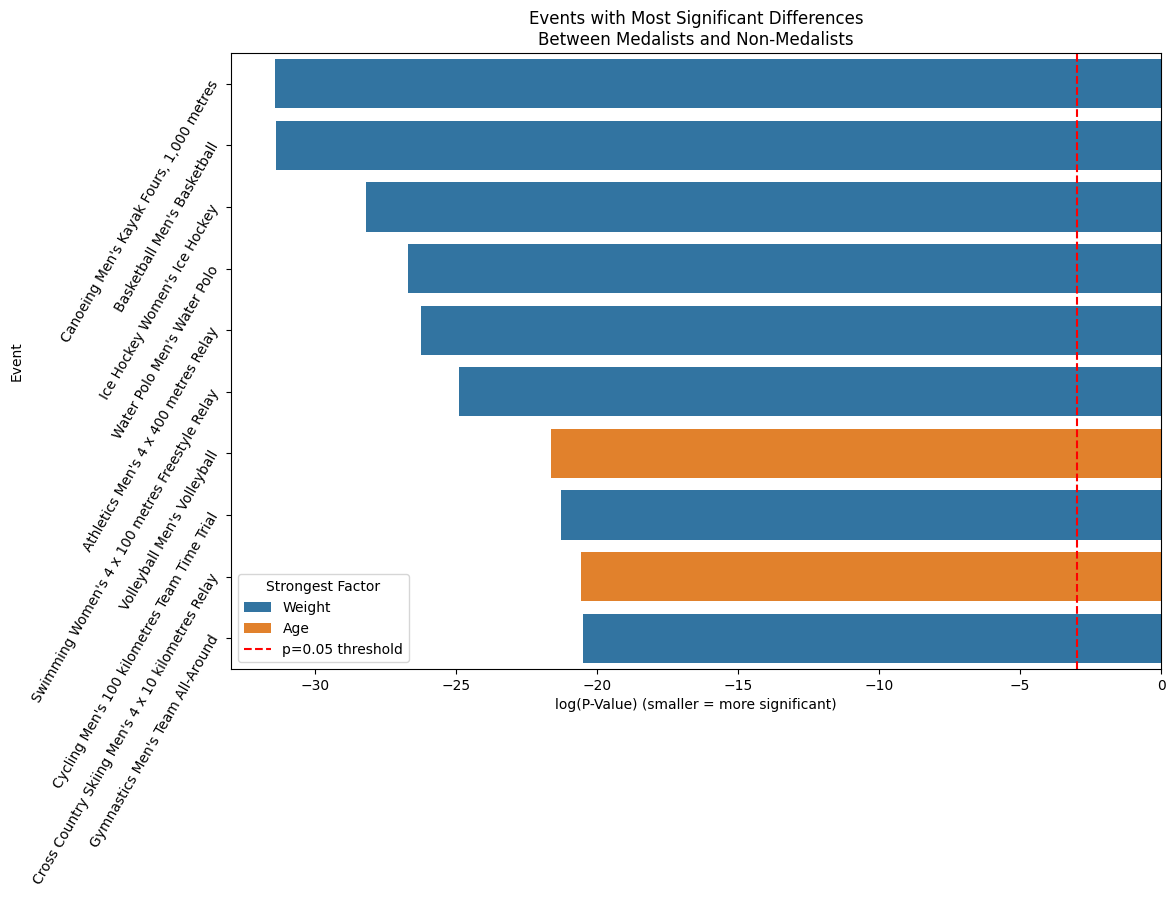

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# We just look whether they have a medal or not
df['Medal_numeric'] = (~df['Medal'].isna()).astype(int)

# Function to analyze distributions by event
def compare_attribute_distributions():

    event_counts = df['Event'].value_counts()
    valid_events = event_counts[event_counts >= 500].index.tolist() # This is to avoid some weird event that they only played in the 1900s, 
    # we saw some gun shooting for example with nonsensical correlations
    
    results = { # to keep for each event
        'Event': [],
        'Height_pvalue': [],
        'Weight_pvalue': [],
        'Age_pvalue': [],
        'Strongest_factor': [],
        'P_value': [],
    }
    
    for event in valid_events:
        event_data = df[df['Event'] == event].copy()
        
        # Split data into medalists and non-medalists
        medalists = event_data[event_data['Medal_numeric'] == 1]
        non_medalists = event_data[event_data['Medal_numeric'] == 0]
        
        # Skip if too few medalists
        if len(medalists) < 10:
            continue
            
        # Calculate Mann-Whitney U test for each attribute (see cell above)
        _, height_p = stats.mannwhitneyu(
            medalists['Height'].dropna(), 
            non_medalists['Height'].dropna(), 
            alternative='two-sided'
        ) if len(medalists['Height'].dropna()) > 0 and len(non_medalists['Height'].dropna()) > 0 else (np.nan, np.nan)
        
        _, weight_p = stats.mannwhitneyu(
            medalists['Weight'].dropna(), 
            non_medalists['Weight'].dropna(), 
            alternative='two-sided'
        ) if len(medalists['Weight'].dropna()) > 0 and len(non_medalists['Weight'].dropna()) > 0 else (np.nan, np.nan)
        
        _, age_p = stats.mannwhitneyu(
            medalists['Age'].dropna(), 
            non_medalists['Age'].dropna(), 
            alternative='two-sided'
        ) if len(medalists['Age'].dropna()) > 0 and len(non_medalists['Age'].dropna()) > 0 else (np.nan, np.nan)
        
        # Find strongest factor (lowest p-value means most significant difference)
        p_values = [height_p, weight_p, age_p]
        factors = ['Height', 'Weight', 'Age']
        
        strongest_idx = np.argmin(p_values)
        
        results['Event'].append(event)
        results['Height_pvalue'].append(height_p)
        results['Weight_pvalue'].append(weight_p)
        results['Age_pvalue'].append(age_p)
        results['Strongest_factor'].append(factors[strongest_idx])
        results['P_value'].append(p_values[strongest_idx])
    
    results_df = pd.DataFrame(results)
    results_df = results_df.sort_values('P_value').reset_index(drop=True) # we sort with at first the smallest p-value (so biggest corr.)
    
    return results_df

# Run analysis
distribution_results = compare_attribute_distributions()

# Plot log p-values (cause p-values are too small, log is better)
plt.figure(figsize=(12, 8))

distribution_results['log_P_value'] = np.log(distribution_results['P_value'])
top_events = distribution_results.head(10)

sns.barplot(x='log_P_value', y='Event', hue='Strongest_factor', data=top_events)
plt.title('Events with Most Significant Differences\nBetween Medalists and Non-Medalists')
plt.xlabel('log(P-Value) (smaller = more significant)')
plt.ylabel('Event')
plt.axvline(x=np.log(0.05), color='red', linestyle='--', label='p=0.05 threshold')
plt.legend(title='Strongest Factor')
plt.yticks(rotation=60)

plt.show()

In [12]:
distribution_results.head()

,Event,Height_pvalue,Weight_pvalue,Age_pvalue,Strongest_factor,P_value,log_P_value
0,"Canoeing Men's Kayak Fours, 1,000 metres",1.918695e-08,2.278512e-14,0.086887,Weight,2.278512e-14,-31.412669
1,Basketball Men's Basketball,1.861836e-13,2.345346e-14,0.945314,Weight,2.345346e-14,-31.383758
2,Ice Hockey Women's Ice Hockey,8.211889e-08,5.702212e-13,0.047041,Weight,5.702212e-13,-28.192752
3,Water Polo Men's Water Polo,2.643434e-09,2.530720e-12,0.009759,Weight,2.530720e-12,-26.702517
4,Athletics Men's 4 x 400 metres Relay,3.299247e-07,4.024965e-12,0.011515,Weight,4.024965e-12,-26.238505


## Visualize distributions of properties

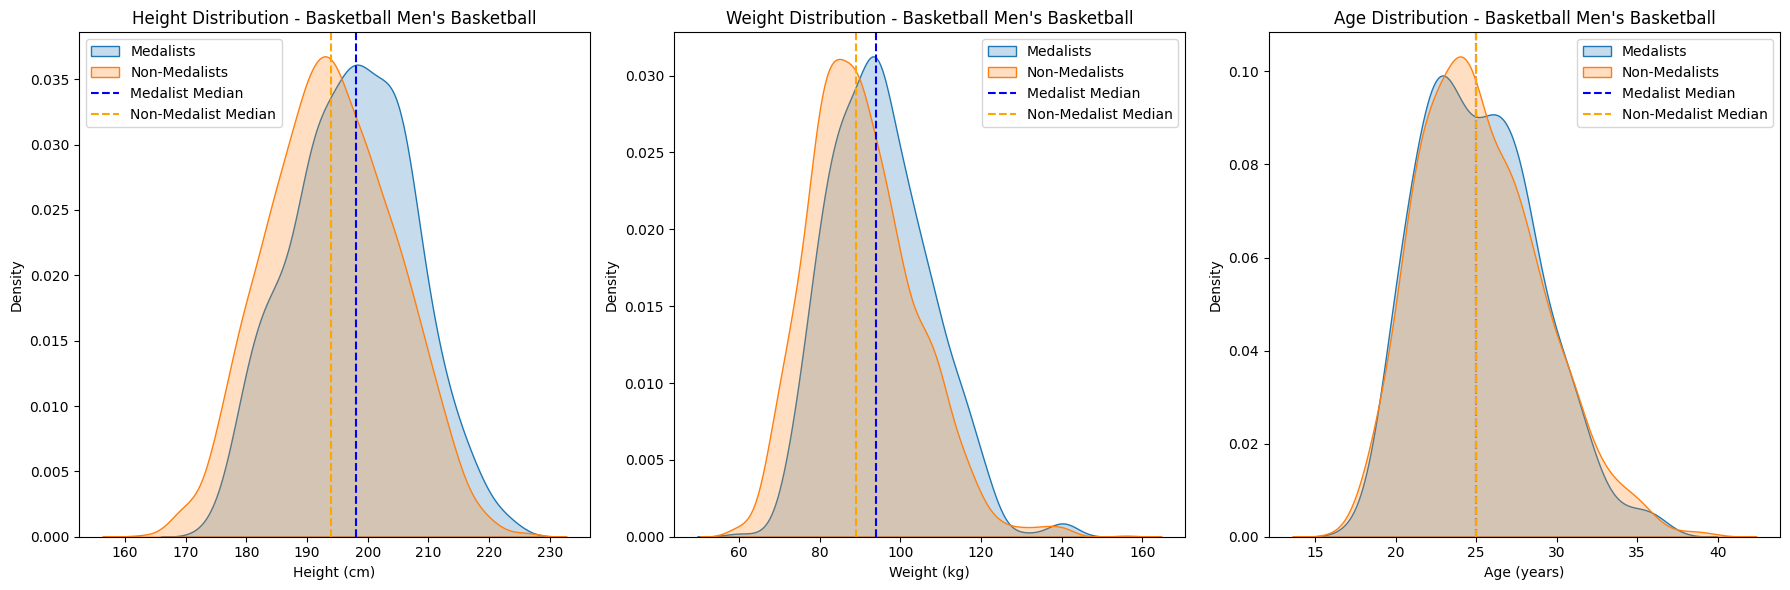

In [13]:
event_name = "Basketball Men\'s Basketball" #distribution_results.iloc[0]['Event']

event_data = df[df['Event'] == event_name].copy()

medalists = event_data[event_data['Medal_numeric'] == 1]
non_medalists = event_data[event_data['Medal_numeric'] == 0]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Height
sns.kdeplot(medalists['Height'].dropna(), ax=axes[0], label='Medalists', fill=True)
sns.kdeplot(non_medalists['Height'].dropna(), ax=axes[0], label='Non-Medalists', fill=True)
axes[0].set_title(f'Height Distribution - {event_name}')
axes[0].set_xlabel('Height (cm)')
axes[0].axvline(medalists['Height'].median(), color='blue', linestyle='--', label='Medalist Median')
axes[0].axvline(non_medalists['Height'].median(), color='orange', linestyle='--', label='Non-Medalist Median')
axes[0].legend()

# Weight
sns.kdeplot(medalists['Weight'].dropna(), ax=axes[1], label='Medalists', fill=True)
sns.kdeplot(non_medalists['Weight'].dropna(), ax=axes[1], label='Non-Medalists', fill=True)
axes[1].set_title(f'Weight Distribution - {event_name}')
axes[1].set_xlabel('Weight (kg)')
axes[1].axvline(medalists['Weight'].median(), color='blue', linestyle='--', label='Medalist Median')
axes[1].axvline(non_medalists['Weight'].median(), color='orange', linestyle='--', label='Non-Medalist Median')
axes[1].legend()

# Age
sns.kdeplot(medalists['Age'].dropna(), ax=axes[2], label='Medalists', fill=True)
sns.kdeplot(non_medalists['Age'].dropna(), ax=axes[2], label='Non-Medalists', fill=True)
axes[2].set_title(f'Age Distribution - {event_name}')
axes[2].set_xlabel('Age (years)')
axes[2].axvline(medalists['Age'].median(), color='blue', linestyle='--', label='Medalist Median')
axes[2].axvline(non_medalists['Age'].median(), color='orange', linestyle='--', label='Non-Medalist Median')
axes[2].legend()

plt.tight_layout()

This would be interesting to further go by looking at the variation of these distributions over different period of time

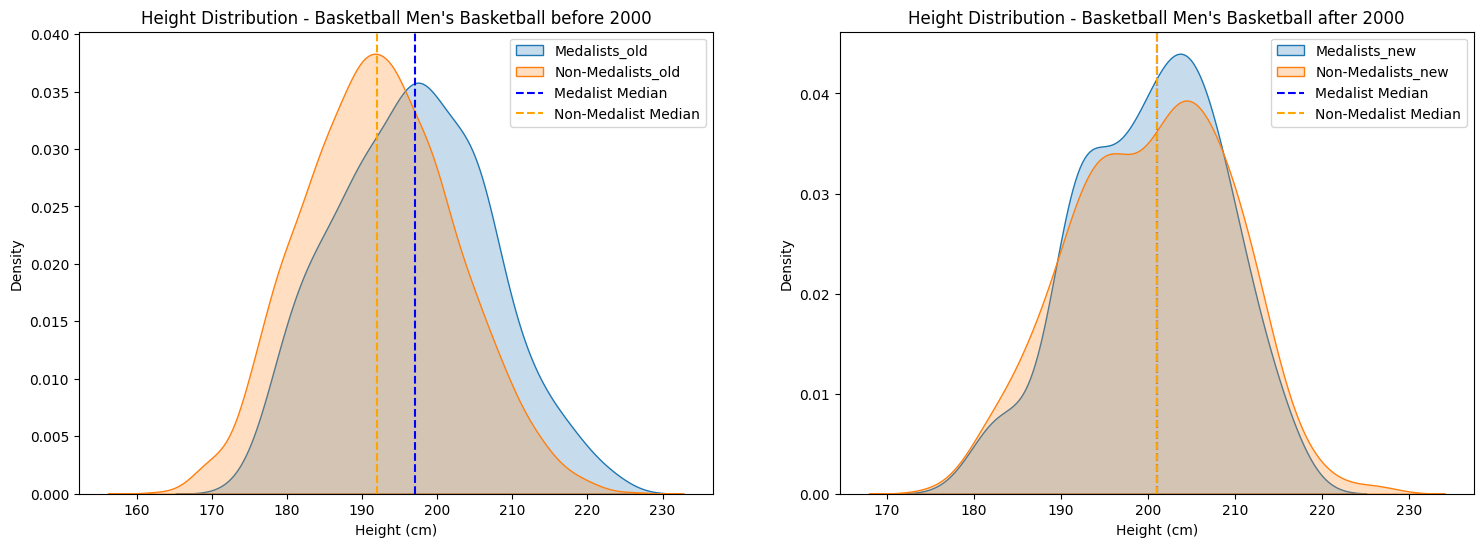

In [14]:
event_name = "Basketball Men\'s Basketball" #distribution_results.iloc[0]['Event']

event_data = df[df['Event'] == event_name].copy()

cutoff_year = 2000
event_old = event_data[event_data['Year'] <= cutoff_year]
event_new = event_data[event_data['Year'] >  cutoff_year]
medalists_old = event_old[event_old['Medal_numeric'] == 1]
non_medalists_old = event_old[event_old['Medal_numeric'] == 0]

medalists_new = event_new[event_new['Medal_numeric'] == 1]
non_medalists_new = event_new[event_new['Medal_numeric'] == 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Height
sns.kdeplot(medalists_old['Height'].dropna(), ax=axes[0], label='Medalists_old', fill=True)
sns.kdeplot(non_medalists_old['Height'].dropna(), ax=axes[0], label='Non-Medalists_old', fill=True)
axes[0].set_title(f'Height Distribution - {event_name} before {cutoff_year}')
axes[0].set_xlabel('Height (cm)')
axes[0].axvline(medalists_old['Height'].median(), color='blue', linestyle='--', label='Medalist Median')
axes[0].axvline(non_medalists_old['Height'].median(), color='orange', linestyle='--', label='Non-Medalist Median')
axes[0].legend()


sns.kdeplot(medalists_new['Height'].dropna(), ax=axes[1], label='Medalists_new', fill=True)
sns.kdeplot(non_medalists_new['Height'].dropna(), ax=axes[1], label='Non-Medalists_new', fill=True)
axes[1].set_title(f'Height Distribution - {event_name} after {cutoff_year}')
axes[1].set_xlabel('Height (cm)')
axes[1].axvline(medalists_new['Height'].median(), color='blue', linestyle='--', label='Medalist Median')
axes[1].axvline(non_medalists_new['Height'].median(), color='orange', linestyle='--', label='Non-Medalist Median')
axes[1].legend()

Fascinating ! It seems like the difference is evolving over time :O